In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats
warnings.filterwarnings("ignore")

In [3]:
ownership = pd.read_csv('Ownership_Investment_2020.csv')
research = pd.read_csv('Research_Payments_2020.csv')
general = pd.read_csv('General_Payments_2020.csv', parse_dates=['Date_of_Payment', 'Payment_Publication_Date'], 
                     dtype={'Teaching_Hospital_CCN': np.float32,'Teaching_Hospital_ID': np.float16, 'Physician_Profile_ID' : np.float32, 'Total_Amount_of_Payment_USDollars': np.float32, 'Number_of_Payments_in_Total_Amount': np.int16, 'Record_ID': np.int32})

list_str_obj_cols = general.columns[general.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    general[str_obj_col] = general[str_obj_col].astype("category")

# Some simple EDAs and visualization

In [33]:
temp = general['Total_Amount_of_Payment_USDollars']

In [48]:
temp.describe()

count    5.767202e+06
mean     3.426843e+02
std      2.068354e+04
min      1.000000e-02
25%      1.314000e+01
50%      1.697000e+01
75%      2.392000e+01
max      1.602908e+07
Name: Total_Amount_of_Payment_USDollars, dtype: float64

### Let's try to see how many outliers we might need to remove in order to obtain a normal distribution

In [34]:
k2, p = stats.normaltest(temp)

In [35]:
display(k2, p)

32507996.332470223

0.0

### So as of now, the test does not yield/signal a normal distribution

In [45]:
length = len(temp)
remove = int(0.999995 * length)

In [46]:
new = pd.DataFrame(temp).sort_values(by='Total_Amount_of_Payment_USDollars', ascending=False)[remove:]

In [47]:
k2, p = stats.normaltest(new)
display(k2,p)

array([407.72556], dtype=float32)

array([2.9075057e-89])

### Observation is that alot of the data values are considerably low and there's a huge gap between the highest amount and lowest amount

In [3]:
payment_by_states = general.groupby(by='Recipient_State').sum().sort_values('Total_Amount_of_Payment_USDollars', ascending=False)['Total_Amount_of_Payment_USDollars']

In [4]:
payment_by_states = pd.DataFrame(payment_by_states)

<AxesSubplot:xlabel='Recipient_State'>

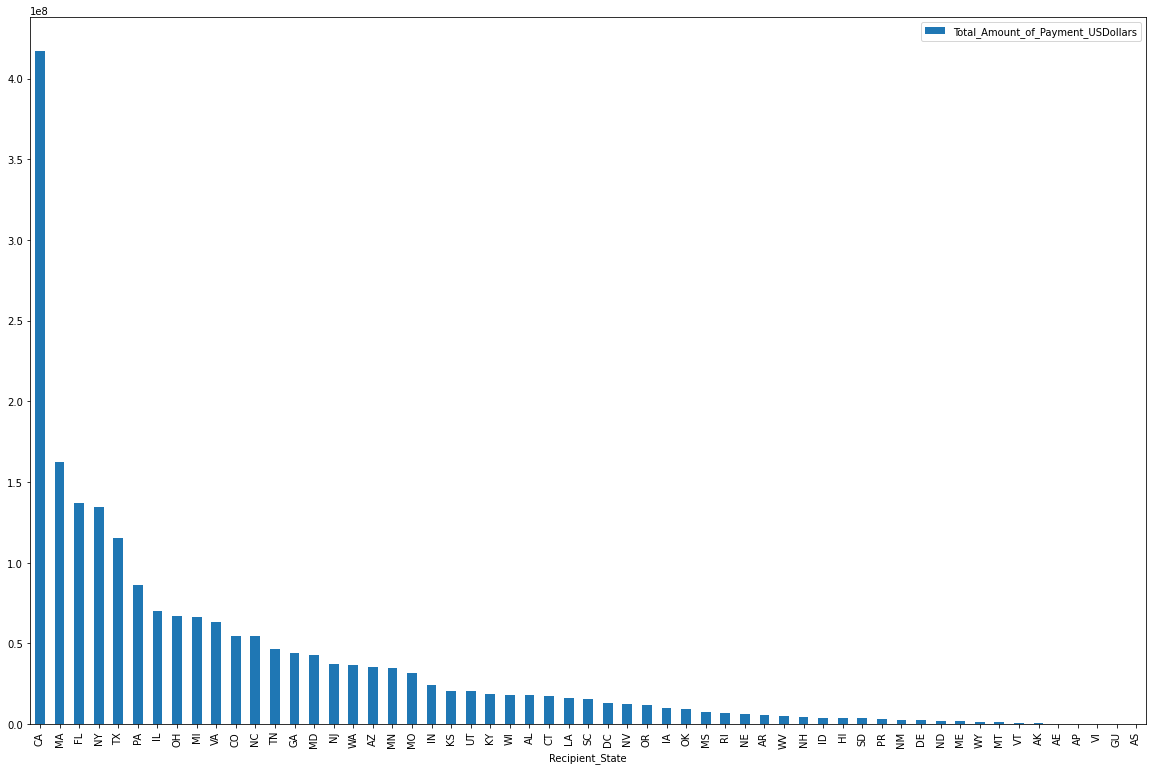

In [5]:
payment_by_states.plot(kind='bar', figsize=(20,13))

### Multidimensional input

In [4]:
general_copy = general[['Recipient_State', 'Physician_Primary_Type', 'Physician_Specialty', 'Total_Amount_of_Payment_USDollars', 'Number_of_Payments_in_Total_Amount']]
general_copy.isna().sum()

Recipient_State                         235
Physician_Primary_Type                31855
Physician_Specialty                   31995
Total_Amount_of_Payment_USDollars         0
Number_of_Payments_in_Total_Amount        0
dtype: int64

In [5]:
general_copy.Recipient_State.dtypes

CategoricalDtype(categories=['AE', 'AK', 'AL', 'AP', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT',
                  'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN',
                  'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
                  'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
                  'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
                  'VA', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY'],
, ordered=False)

In [6]:
le = preprocessing.LabelEncoder()
temp = le.fit(general_copy.Recipient_State)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

general_copy.Recipient_State = temp.transform(general_copy.Recipient_State)
general_copy

{'AE': 0, 'AK': 1, 'AL': 2, 'AP': 3, 'AR': 4, 'AS': 5, 'AZ': 6, 'CA': 7, 'CO': 8, 'CT': 9, 'DC': 10, 'DE': 11, 'FL': 12, 'GA': 13, 'GU': 14, 'HI': 15, 'IA': 16, 'ID': 17, 'IL': 18, 'IN': 19, 'KS': 20, 'KY': 21, 'LA': 22, 'MA': 23, 'MD': 24, 'ME': 25, 'MI': 26, 'MN': 27, 'MO': 28, 'MS': 29, 'MT': 30, 'NC': 31, 'ND': 32, 'NE': 33, 'NH': 34, 'NJ': 35, 'NM': 36, 'NV': 37, 'NY': 38, 'OH': 39, 'OK': 40, 'OR': 41, 'PA': 42, 'PR': 43, 'RI': 44, 'SC': 45, 'SD': 46, 'TN': 47, 'TX': 48, 'UT': 49, 'VA': 50, 'VI': 51, 'VT': 52, 'WA': 53, 'WI': 54, 'WV': 55, 'WY': 56, nan: 57}


,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
0,38,Medical Doctor,Allopathic & Osteopathic Physicians|Pain Medic...,14875.000000,1
1,38,Doctor of Dentistry,Dental Providers|Dentist,5296.000000,1
2,18,Doctor of Dentistry,Dental Providers|Dentist,1050.000000,1
3,27,Medical Doctor,Allopathic & Osteopathic Physicians|Orthopaedi...,4750.000000,1
4,35,Chiropractor,Chiropractic Providers|Chiropractor,320.000000,1
...,...,...,...,...,...
5767197,36,Medical Doctor,Allopathic & Osteopathic Physicians|Plastic Su...,107.699997,1
5767198,36,Medical Doctor,Allopathic & Osteopathic Physicians|Plastic Su...,4500.000000,1
5767199,36,Medical Doctor,Allopathic & Osteopathic Physicians|Plastic Su...,40.130001,1
5767200,36,Medical Doctor,Allopathic & Osteopathic Physicians|Plastic Su...,666.580017,1


In [7]:
le_2 = preprocessing.LabelEncoder()
temp_2 = le_2.fit(general_copy.Physician_Primary_Type)
le_name_mapping_2 = dict(zip(le_2.classes_, le_2.transform(le_2.classes_)))
print(le_name_mapping_2)

general_copy.Physician_Primary_Type = temp_2.transform(general_copy.Physician_Primary_Type)
general_copy

{'Chiropractor': 0, 'Doctor of Dentistry': 1, 'Doctor of Optometry': 2, 'Doctor of Osteopathy': 3, 'Doctor of Podiatric Medicine': 4, 'Medical Doctor': 5, nan: 6}


,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
0,38,5,Allopathic & Osteopathic Physicians|Pain Medic...,14875.000000,1
1,38,1,Dental Providers|Dentist,5296.000000,1
2,18,1,Dental Providers|Dentist,1050.000000,1
3,27,5,Allopathic & Osteopathic Physicians|Orthopaedi...,4750.000000,1
4,35,0,Chiropractic Providers|Chiropractor,320.000000,1
...,...,...,...,...,...
5767197,36,5,Allopathic & Osteopathic Physicians|Plastic Su...,107.699997,1
5767198,36,5,Allopathic & Osteopathic Physicians|Plastic Su...,4500.000000,1
5767199,36,5,Allopathic & Osteopathic Physicians|Plastic Su...,40.130001,1
5767200,36,5,Allopathic & Osteopathic Physicians|Plastic Su...,666.580017,1


In [8]:
le_3 = preprocessing.LabelEncoder()
temp_3 = le_3.fit(general_copy.Physician_Specialty)
le_name_mapping_3 = dict(zip(le_3.classes_, le_3.transform(le_3.classes_)))
print(le_name_mapping_3)

general_copy.Physician_Specialty = temp_3.transform(general_copy.Physician_Specialty)
general_copy

{'Allopathic & Osteopathic Physicians|Allergy & Immunology': 0, 'Allopathic & Osteopathic Physicians|Allergy & Immunology|Allergy': 1, 'Allopathic & Osteopathic Physicians|Allergy & Immunology|Clinical & Laboratory Immunology': 2, 'Allopathic & Osteopathic Physicians|Anesthesiology': 3, 'Allopathic & Osteopathic Physicians|Anesthesiology|Addiction Medicine': 4, 'Allopathic & Osteopathic Physicians|Anesthesiology|Critical Care Medicine': 5, 'Allopathic & Osteopathic Physicians|Anesthesiology|Hospice and Palliative Medicine': 6, 'Allopathic & Osteopathic Physicians|Anesthesiology|Pain Medicine': 7, 'Allopathic & Osteopathic Physicians|Anesthesiology|Pediatric Anesthesiology': 8, 'Allopathic & Osteopathic Physicians|Clinical Pharmacology': 9, 'Allopathic & Osteopathic Physicians|Colon & Rectal Surgery': 10, 'Allopathic & Osteopathic Physicians|Dermatology': 11, 'Allopathic & Osteopathic Physicians|Dermatology|Clinical & Laboratory Dermatological Immunology': 12, 'Allopathic & Osteopathic 

,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
0,38,5,114,14875.000000,1
1,38,1,237,5296.000000,1
2,18,1,237,1050.000000,1
3,27,5,98,4750.000000,1
4,35,0,223,320.000000,1
...,...,...,...,...,...
5767197,36,5,164,107.699997,1
5767198,36,5,164,4500.000000,1
5767199,36,5,164,40.130001,1
5767200,36,5,164,666.580017,1


# Outlier Algorithms

### Simple function to make predicting and visualizing outliers easier with the isolation forest algo

In [10]:
"""
What the inputs refer to 

dataset - which dataset do you wish to analyze
state - which state do you wish to analyze
column_to_plot - which column do you wish the y-axis to show you 
n_estimators - hyperparam for isolationforest 
contamination - another hyperparam; the higher the number, the more outliers / the more lenient the model would be 
"""

def isolationforestoutlier(dataset, state, column_to_plot, n_estimators=200, contamination=0.01):
    dataset = dataset.where(dataset['Recipient_State'] == state)
    dataset.dropna(subset=['Recipient_State'], inplace=True)
    dataset = dataset.sort_values(column_to_plot, ascending=False)

    input_matrix = np.array(dataset[column_to_plot]).reshape(-1,1)
        
    print("Predicting\n")
    model = IsolationForest(n_estimators = n_estimators, contamination = contamination, n_jobs=-1, random_state = 42).fit(input_matrix)
    result = model.predict(input_matrix)
    print("Finished predicting\n")
    print("Checking for outliers\n")
    temp = result == -1 # Checking for outliers
    index = [] 
    for i in range(len(temp)):
        if temp[i] == True:
            index.append(i)
    indexs = [] # List containing the index of outliers
    for value in index:
        indexs.append(dataset[column_to_plot].index[value])
    
    print("We have {} outliers in total\n".format(len(indexs)))
    print("{:.2}% are outliers in this dataset\n".format(len(indexs)/len(dataset)))
    
    print("The indexes of the outliers are" , indexs)
    #print(pd.DataFrame(dataset.loc[indexs])) # Uncomment if you wish to visualize the outliers
        
    print("\n Plotting graph now\n")
    # Plotting
    x_1 = [] # Outliers
    y_1 = []
    for value in indexs:
        x_1.append(value)
        y_1.append(dataset[column_to_plot][value])
        dataset.drop(value, inplace=True)

    fig = plt.figure(figsize=(15, 10), dpi=80)
    plt.title("In {}".format(state))
    plt.xlabel('Index')
    plt.ylabel('{}'.format(column_to_plot))
    ax1 = fig.add_subplot()

    ax1.scatter(x=x_1, y=y_1, s=10, c='r', label='Outliers')
    ax1.scatter(x=dataset.index, y=dataset[column_to_plot], s=10, c='b', label='Inliers')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
x_1 = [] # Outliers
y_1 = []
for value in index:
    x_1.append(value)
    y_1.append(dataset[column_to_plot][value])
    dataset.drop(value, inplace=True)

fig = plt.figure(figsize=(15, 10), dpi=80)
plt.title("In {}".format(state))
plt.xlabel('Index')
plt.ylabel('{}'.format(column_to_plot))
ax1 = fig.add_subplot()

ax1.scatter(x=x_1, y=y_1, s=10, c='r', label='Outliers')
ax1.scatter(x=dataset.index, y=dataset[column_to_plot], s=10, c='b', label='Inliers')
plt.legend(loc='upper left')
plt.show()

# Multi-Dimensional Isolation Forest Algo

In [9]:
input_matrix = np.array(general_copy)

In [23]:
model = IsolationForest(n_estimators = 200,contamination = 0.01, n_jobs=-1, random_state = 42).fit(input_matrix)
result = model.predict(input_matrix)

In [24]:
temp = result == -1 # Checking for outliers
index = [] 
for i in range(len(temp)):
    if temp[i] == True:
        index.append(i)

### The rows from the general_payments dataset that are classified as outliers

In [25]:
outlier_general_copy = general_copy.loc[index]
outlier_general_copy

,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
0,38,5,114,14875.0000,1
1,38,1,237,5296.0000,1
2,18,1,237,1050.0000,1
9,50,6,271,1775.0000,1
23,8,5,209,8000.0000,1
...,...,...,...,...,...
5767170,38,5,209,7150.0000,1
5767179,7,5,209,5200.0000,1
5767185,31,5,209,16250.0000,1
5767190,1,5,220,165849.9375,1


In [26]:
outlier_general_copy.Recipient_State = le.inverse_transform(outlier_general_copy.Recipient_State)
outlier_general_copy.Physician_Primary_Type = le_2.inverse_transform(outlier_general_copy.Physician_Primary_Type)
outlier_general_copy.Physician_Specialty = le_3.inverse_transform(outlier_general_copy.Physician_Specialty)

In [27]:
outlier_general_copy.sort_values(by='Total_Amount_of_Payment_USDollars', ascending=False)[:20]

,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
2299889,FL,Medical Doctor,Allopathic & Osteopathic Physicians|Neurologic...,16029083.0,1
1110073,CA,Medical Doctor,Allopathic & Osteopathic Physicians|Radiology|...,10050385.0,1
3435665,CA,NaN,NaN,9800015.0,1
3435660,CA,NaN,NaN,9205620.0,1
3435658,CA,NaN,NaN,8358713.0,1
4653620,MD,Medical Doctor,Allopathic & Osteopathic Physicians|Orthopaedi...,8250000.0,1
3435630,CA,NaN,NaN,8121447.5,1
1475961,MA,NaN,NaN,8057036.5,1
3435663,CA,NaN,NaN,7946206.0,1
2596809,MA,NaN,NaN,7756092.0,1


In [70]:
pd.DataFrame(outlier_general_copy.Recipient_State.value_counts())[:10]

,Recipient_State
CA,8299
TX,4536
NY,3563
FL,3263
PA,2848
MA,2276
OH,2240
WA,2178
AZ,2134
IL,2051


In [52]:
pd.DataFrame(outlier_general_copy.Recipient_State.value_counts()).describe()

,Recipient_State
count,54.000000
mean,1067.574074
std,1428.535305
min,3.000000
25%,168.000000
50%,530.500000
75%,1479.500000
max,8299.000000


### The rows of general dataset (California) classified as outliers from multidimensional input

In [90]:
frames = []
for i in range(1,6):
    #display(pd.DataFrame(pd.DataFrame(general.loc[general['Recipient_State'] == 'CA']).groupby(by='Product_Name_{}'.format(i)).sum().sort_values(by='Total_Amount_of_Payment_USDollars', ascending=False)['Total_Amount_of_Payment_USDollars'][:10]))
    frames.append(pd.DataFrame(pd.DataFrame(general.loc[general['Recipient_State'] == 'CA']).groupby(by='Product_Name_{}'.format(i)).sum().sort_values(by='Total_Amount_of_Payment_USDollars', ascending=False)['Total_Amount_of_Payment_USDollars'][:10]))
result = pd.concat(frames)
result[:10]

,Total_Amount_of_Payment_USDollars
OCREVUS,39461440.0
InPen,38779324.0
Perjeta,29634030.0
BOTOX COSMETIC,19507158.0
Herceptin,15934571.0
Rituxan,12115965.0
Avastin,7592234.0
SHOULDER IMPLANTS SWIVELOCKS COMPOSITE ANCHORS,5327714.0
Da Vinci Surgical System,5247255.0
Xolair,5056345.0


In [91]:
result.groupby(by=result.index).sum().sort_values('Total_Amount_of_Payment_USDollars', ascending=False)[:20]

,Total_Amount_of_Payment_USDollars
OCREVUS,3.946144e+07
InPen,3.877932e+07
Perjeta,2.963403e+07
BOTOX COSMETIC,2.046444e+07
Herceptin,1.593457e+07
Rituxan,1.211596e+07
SHOULDER IMPLANTS SWIVELOCKS PEEK ANCHORS,7.638472e+06
SHOULDER IMPLANTS SWIVELOCKS COMPOSITE ANCHORS,7.638472e+06
SHOULDER IMPLANTS SPEEDBRIDGE COMPOSITE ANCHORS,7.638472e+06
DISTAL EXTREMITIES IMPLANTS SOFT TISSUE TENODESIS,7.638472e+06


In [30]:
general.loc[list(outlier_general_copy.index)].sort_values(by='Total_Amount_of_Payment_USDollars', ascending=False)[['Teaching_Hospital_Name', 'Physician_Profile_ID', 'Recipient_State', 'Manufacturer_or_GPO_State', 'Manufacturer_or_GPO_Name', 'Product_Name_1']][:20]

,Teaching_Hospital_Name,Physician_Profile_ID,Recipient_State,Manufacturer_or_GPO_State,Manufacturer_or_GPO_Name,Product_Name_1
2299889,NaN,194200.0,FL,MN,"Medtronic Vascular, Inc.",Ellipsys
1110073,NaN,1394141.0,CA,MN,"Medtronic MiniMed, Inc.",InPen
3435665,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc.",OCREVUS
3435660,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc.",OCREVUS
3435658,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc.",OCREVUS
4653620,NaN,198346.0,MD,CO,"Paragon 28, Inc.",NaN
3435630,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc.",Perjeta
1475961,Dana-Farber Cancer Institute,NaN,MA,DE,AstraZeneca Pharmaceuticals LP,IMFINZI
3435663,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc.",OCREVUS
2596809,Dana-Farber Cancer Institute,NaN,MA,DE,AstraZeneca Pharmaceuticals LP,IMFINZI


### Some examples of the function

Predicting

Finished predicting

Checking for outliers

We have 50 outliers in total

8.3e-05% are outliers in this dataset

The indexes of the outliers are [1110073, 3435665, 3435660, 3435658, 3435630, 3435663, 1110093, 3435627, 957139, 957134, 1110072, 3435606, 3435596, 3435609, 3435636, 957137, 1110089, 3435580, 3435633, 3435629, 2299906, 3435575, 3435612, 3435588, 3435712, 3435628, 3435569, 3435551, 3435632, 1110074, 3559951, 3435567, 3435555, 3435585, 4653626, 3435591, 3435577, 3559966, 3559968, 3435579, 3435639, 3435562, 957135, 1110094, 3435572, 3435634, 4559259, 3435642, 3559967, 1110071]

 Plotting graph now



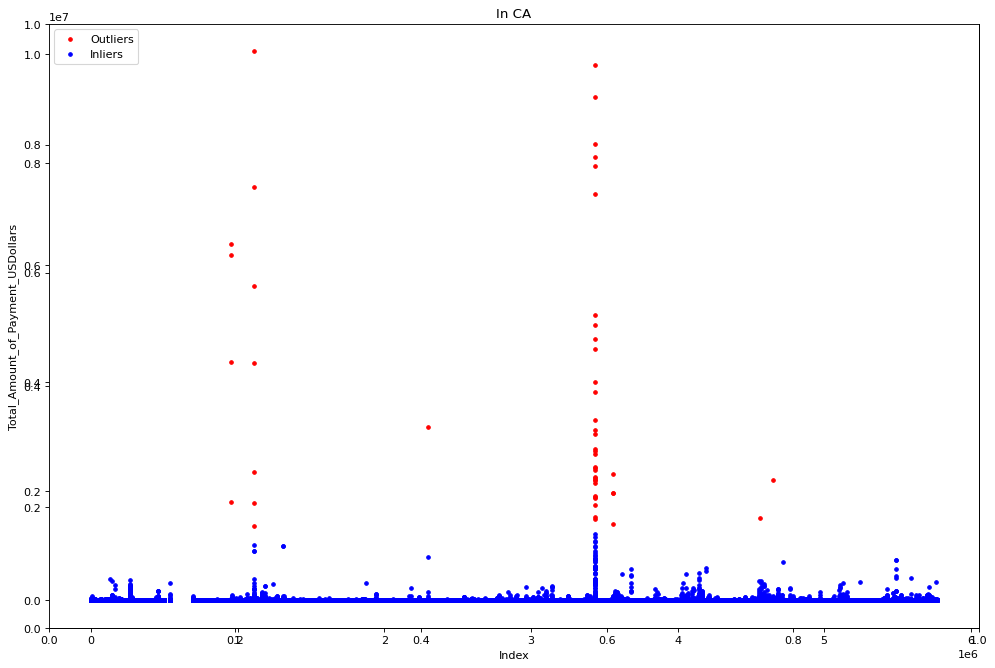

In [19]:
isolationforestoutlier(general, 'CA', 'Total_Amount_of_Payment_USDollars', 200, 0.0001)

Predicting

Finished predicting

Checking for outliers

We have 3 outliers in total

0.01% are outliers in this dataset

The indexes of the outliers are [2925, 2224, 2363]

 Plotting graph now



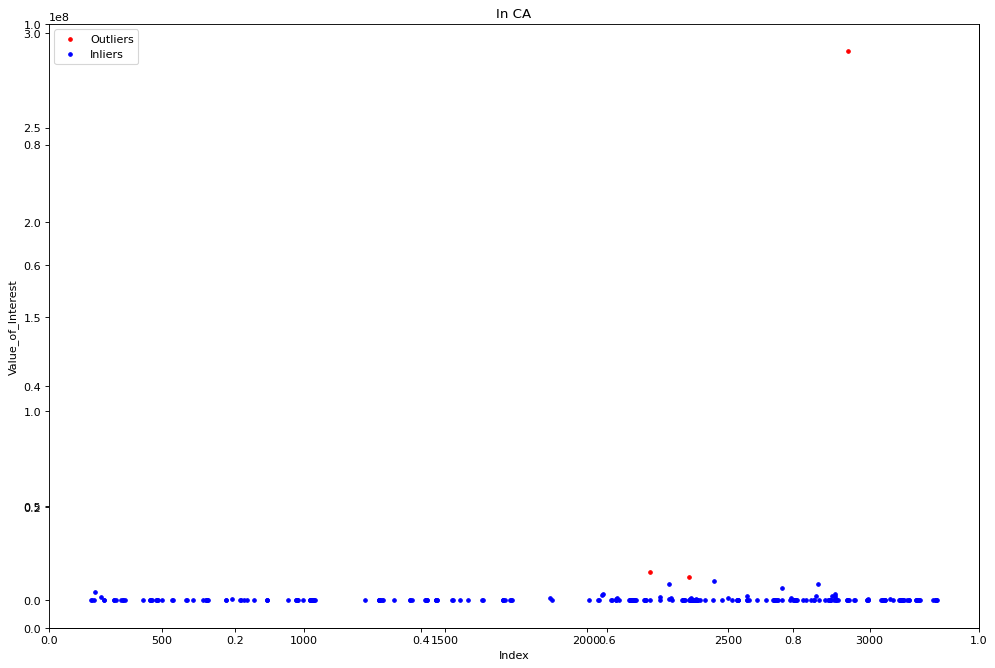

In [20]:
isolationforestoutlier(ownership, 'CA', 'Value_of_Interest', 200, 0.01)

### Some simple analysis

<AxesSubplot:ylabel='Density'>

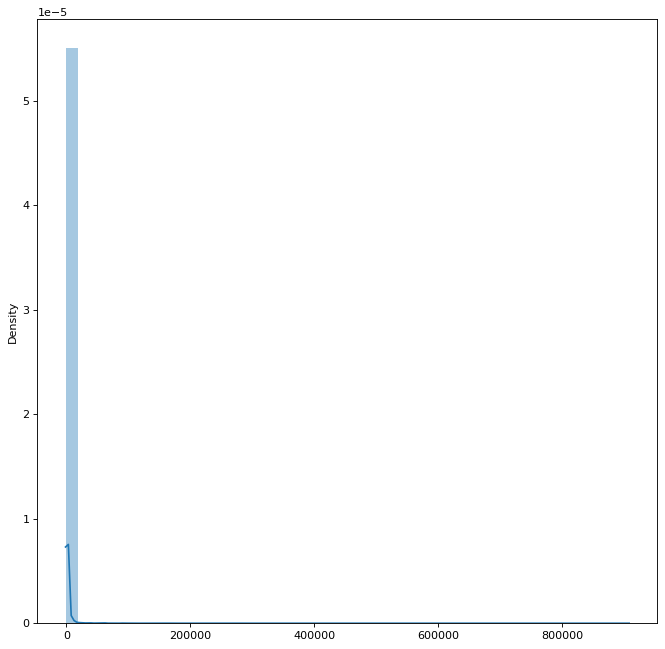

In [21]:
general_ca = general.where(general['Recipient_State'] == 'CA')
general_ca.dropna(subset=['Recipient_State'], inplace=True)
general_ca = general_ca.sort_values('Total_Amount_of_Payment_USDollars', ascending=False)

general_ca_copy = general_ca.copy()

for value in [1110073, 3435665, 3435660, 3435658, 3435630, 3435663, 1110093, 3435627, 957139, 957134, 1110072, 3435606, 3435596, 3435609, 3435636, 957137, 1110089, 3435580, 3435633, 3435629, 2299906, 3435575, 3435612, 3435588, 3435712, 3435628, 3435569, 3435551, 3435632, 1110074, 3559951, 3435567, 3435555, 3435585, 4653626, 3435591, 3435577, 3559966, 3559968, 3435579, 3435639, 3435562, 957135, 1110094, 3435572, 3435634, 4559259, 3435642, 3559967, 1110071, 3435644, 3435669, 3435664, 3435662, 1110090, 1312014, 1312010, 3435650, 3435667]:
    general_ca_copy.drop(value, inplace=True)
    
temp = pd.DataFrame(general_ca_copy['Total_Amount_of_Payment_USDollars'])
plt.figure(figsize=(10, 10), dpi=80)
sns.distplot(temp)

In [22]:
general_ca.loc[[1110073, 3435665, 3435660, 3435658, 3435630, 3435663, 1110093, 3435627, 957139, 957134, 1110072, 3435606, 3435596, 3435609, 3435636, 957137, 1110089, 3435580, 3435633, 3435629, 2299906, 3435575, 3435612, 3435588, 3435712, 3435628, 3435569, 3435551, 3435632, 1110074, 3559951, 3435567, 3435555, 3435585, 4653626, 3435591, 3435577, 3559966, 3559968, 3435579, 3435639, 3435562, 957135, 1110094, 3435572, 3435634, 4559259, 3435642, 3559967, 1110071, 3435644, 3435669, 3435664, 3435662, 1110090, 1312014, 1312010, 3435650, 3435667]]['Product_Category_or_Therapeutic_Area_1'].unique().to_list()

['Continuous Glucose Monitoring',
 'Immunology',
 'BioOncology',
 nan,
 'BioOncology/Immunology',
 'Catheters',
 'SHOULDER',
 'SPINE',
 'Orthopedics/Orthopedic Surgery']

# Cancer Mortality Analysis

In [92]:
cancer = pd.read_csv('cancer_mortality.csv')

In [114]:
cancer[cancer['YEAR'] == 2020].sort_values(by='RATE')[['STATE', 'RATE']].head(10).reset_index()

,index,STATE,RATE
0,43,UT,119.5
1,10,HI,123.8
2,5,CO,127.2
3,2,AZ,127.7
4,31,NY,128.8
5,30,NM,129.8
6,4,CA,130.3
7,29,NJ,133.4
8,6,CT,133.8
9,20,MA,135.2


# Analyzing for KT

In [120]:
frames = []
for i in range(1,6):
    #display(pd.DataFrame(pd.DataFrame(general.loc[general['Recipient_State'] == 'KT']).groupby(by='Product_Name_{}'.format(i)).sum().sort_values(by='Total_Amount_of_Payment_USDollars', ascending=False)['Total_Amount_of_Payment_USDollars'][:10]))
    frames.append(pd.DataFrame(pd.DataFrame(general.loc[general['Recipient_State'] == 'KY']).groupby(by='Product_Name_{}'.format(i)).sum().sort_values(by='Total_Amount_of_Payment_USDollars', ascending=False)['Total_Amount_of_Payment_USDollars'][:10]))
result = pd.concat(frames)
result[:10]

,Total_Amount_of_Payment_USDollars
Bridle,836033.312500
REUNION,761505.187500
Aptis DRUJ,735075.187500
MAKO,351881.750000
Da Vinci Surgical System,343442.750000
UBRELVY,238400.906250
FARXIGA,201444.125000
ILUMYA,184200.406250
JARDIANCE,159928.046875
XARELTO,153010.593750


In [121]:
result.groupby(by=result.index).sum().sort_values('Total_Amount_of_Payment_USDollars', ascending=False)[:20]

,Total_Amount_of_Payment_USDollars
REUNION,1.075485e+06
Bridle,8.360333e+05
Aptis DRUJ,7.350752e+05
MAKO,3.518818e+05
Da Vinci Surgical System,3.434428e+05
ACCOLADE,3.162297e+05
UBRELVY,2.384009e+05
FARXIGA,2.014441e+05
ARISTADA,1.911371e+05
ILUMYA,1.842004e+05


In [127]:
general.groupby(by='Recipient_State').sum()['Total_Amount_of_Payment_USDollars'].to_csv('state_grouped_csv_file.csv')